In [1]:
import numpy as np
import pandas as pd
import arch
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM
from sklearn.metrics import mean_squared_error
import scipy
from scipy import optimize

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/scipy/__init__.py:137: UserWarning: NumPy 1.16.5 or above is required for this version of SciPy (detected version 1.16.2)
  UserWarning)


# Question 3

In [2]:
monthly_SP500 = pd.read_csv('mon_ret.csv')
daily_SP500 = pd.read_csv('day_ret.csv')

In [3]:
monthly_SP500['Date'] = pd.to_datetime(monthly_SP500['caldt'])
monthly_SP500['Value'] = monthly_SP500['vwretd']

daily_SP500['Date'] = pd.to_datetime(daily_SP500['caldt'])
daily_SP500['Value'] = daily_SP500['vwretd']

monthly_SP500.drop(columns=['caldt', 'vwretd'], inplace=True)
daily_SP500.drop(columns=['caldt', 'vwretd'], inplace=True)

In [4]:
mu = 0.01
omega = 0.0073
alpha = 0.93
beta = 0.06

## 3.1

In [5]:
np.random.seed(100)

n=13200
error_list = np.random.normal(loc=0, scale=1, size=n)
epsilon_list = np.zeros_like(error_list)
sigma_sq_list = np.zeros_like(error_list)
daily_return_list = np.zeros_like(error_list)

sigma_sq_list[0] = omega
epsilon_list[0] = np.sqrt(sigma_sq_list[0])*error_list[0]
daily_return_list[0] = mu + epsilon_list[0]

for i in range(1, n):
    sigma_sq_list[i] = omega + alpha*(epsilon_list[i-1]**2) + beta*sigma_sq_list[i-1]
    epsilon_list[i] = np.sqrt(sigma_sq_list[i])*error_list[i]
    daily_return_list[i] = mu + epsilon_list[i]

monthly_return_list = np.sum(daily_return_list.reshape((600,22)), axis=1)

## 3.2

In [6]:
# Fit GARCH(1,1) using simulated log returns
sim_am = arch.arch_model(monthly_return_list, vol='Garch', p=1, q=1) 
sim_am_fit = sim_am.fit()
print(sim_am_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1444.7592330351179
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1042.430779492922
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1096.3693754235067
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1001.1011906069872
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1000.1437528018495
Iteration:      6,   Func. Count:     36,   Neg. LLF: 999.7967681225705
Iteration:      7,   Func. Count:     41,   Neg. LLF: 999.5136850873464
Iteration:      8,   Func. Count:     46,   Neg. LLF: 999.1376842040677
Iteration:      9,   Func. Count:     51,   Neg. LLF: 998.8130590612179
Iteration:     10,   Func. Count:     56,   Neg. LLF: 998.7356414632656
Iteration:     11,   Func. Count:     61,   Neg. LLF: 998.7164316737626
Iteration:     12,   Func. Count:     66,   Neg. LLF: 998.7160086302614
Iteration:     13,   Func. Count:     71,   Neg. LLF: 998.7159928521223
Iteration:     14,   Func. Count:     75,   Neg. LLF: 998.71

$r_t = 0.2338 +\epsilon_t$

$\epsilon_t = \sigma_t \cdot e_t$

${\sigma_t}^2 = 1.3557 + 0.2892{\epsilon_{t-1}}^2$

$e_t \sim N(0,1) $

Comment: estimated beta is 0, so the model is actually an ARCH(1). Parameters are different from the simulation.

In [7]:
# Fit GARCH(1,1) using monthly SP500 returns
sp500_am = arch.arch_model(monthly_SP500['Value'], vol='Garch', p=1, q=1) 
sp500_am_fit = sp500_am.fit()
print(sp500_am_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 104588362.02301483
Iteration:      2,   Func. Count:     17,   Neg. LLF: 23856.641639410704
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2695.0038055834057
Iteration:      4,   Func. Count:     38,   Neg. LLF: 2828.0311793906376
Iteration:      5,   Func. Count:     48,   Neg. LLF: 1321.1329098363567
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1083.0279859875764
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1126.4227108337475
Iteration:      8,   Func. Count:     72,   Neg. LLF: -1151.1967184937255
Iteration:      9,   Func. Count:     78,   Neg. LLF: -1073.6877728862505
Iteration:     10,   Func. Count:     85,   Neg. LLF: -1152.5161879652273
Iteration:     11,   Func. Count:     90,   Neg. LLF: -1152.5162593708292
Iteration:     12,   Func. Count:     95,   Neg. LLF: -1152.5162627057448
Iteration:     13,   Func. Count:     99,   Neg. LLF: -1152.516262705782
Optimization terminated successfully    (Exi

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


$r_t = 0.0098 +\epsilon_t$

$\epsilon_t = \sigma_t \cdot e_t$

${\sigma_t}^2 = 0.1189{\epsilon_{t-1}}^2 + 0.8559{\sigma_{t-1}}^2$

$e_t \sim N(0,1) $

Comment: estimated omega is 0. Parameters are different from the simulation.

## 3.3

In [8]:
sim_data = daily_return_list.reshape((600,22))
sim_realized_vol = np.sum(sim_data**2, axis=1)

In [9]:
sim_realized_vol

array([ 0.33696419,  0.64452492,  0.82536148,  0.71033854,  2.4260502 ,
        1.8166057 ,  0.66263787,  0.88905317,  0.38591452,  0.41468033,
        0.8088404 ,  0.75799977,  1.12432919, 14.00072638,  1.04972189,
        3.83286656,  0.2987802 ,  0.30686165,  0.28109249,  0.87176439,
        0.37570341,  0.41380882,  1.12748954, 49.21029024,  4.47848142,
        0.72855334,  0.48641925,  0.62873936,  1.4209782 ,  0.34725861,
        0.24751665,  0.5541451 ,  1.25858826,  0.54994952,  0.48292166,
        0.13780333,  0.69854846,  0.66308217,  0.20625372,  0.36708131,
        4.04873239,  2.02098843,  1.58698514,  0.48661718,  0.4213903 ,
        0.49321065,  1.90936743,  0.26448925,  0.32776589,  0.16542695,
        1.31317061,  0.59282267,  0.76015407,  0.12788704,  0.36073315,
        4.21643603,  0.65649163,  0.23154853,  2.50721286,  5.10379464,
        0.91492072,  0.88298146,  0.19077711,  1.25950752,  0.91076804,
        0.31381253,  1.15084063,  1.10284443,  0.51082166,  0.29

In [10]:
sp500_data = np.array(daily_SP500['Value'][1:]).reshape((615,22))
sp500_realized_vol = np.sum(sp500_data**2, axis=1)

In [11]:
sp500_realized_vol

array([0.00047069, 0.00033978, 0.0004403 , 0.00044539, 0.00348084,
       0.00023786, 0.00015733, 0.00010861, 0.00013726, 0.00033965,
       0.00043314, 0.00022755, 0.00035599, 0.00027348, 0.00016534,
       0.00014795, 0.00037695, 0.00021964, 0.00038581, 0.00013608,
       0.00016963, 0.00044791, 0.00181669, 0.00045828, 0.0001653 ,
       0.00027399, 0.0001775 , 0.00029173, 0.00020654, 0.00025188,
       0.00087954, 0.00049762, 0.00163429, 0.0007086 , 0.0007832 ,
       0.00158807, 0.00321782, 0.00272368, 0.00095788, 0.00063015,
       0.00075128, 0.00056099, 0.00048604, 0.00076862, 0.00163825,
       0.00030428, 0.00026229, 0.00025167, 0.00045376, 0.0005842 ,
       0.0007613 , 0.00034125, 0.00083309, 0.00141393, 0.00183557,
       0.00029327, 0.00064197, 0.00084226, 0.00043982, 0.00028966,
       0.00034163, 0.00071548, 0.00025293, 0.00085606, 0.00054862,
       0.00046159, 0.00074363, 0.00154407, 0.00168345, 0.00097486,
       0.00079757, 0.00055606, 0.0011314 , 0.00093524, 0.00131

## 3.4

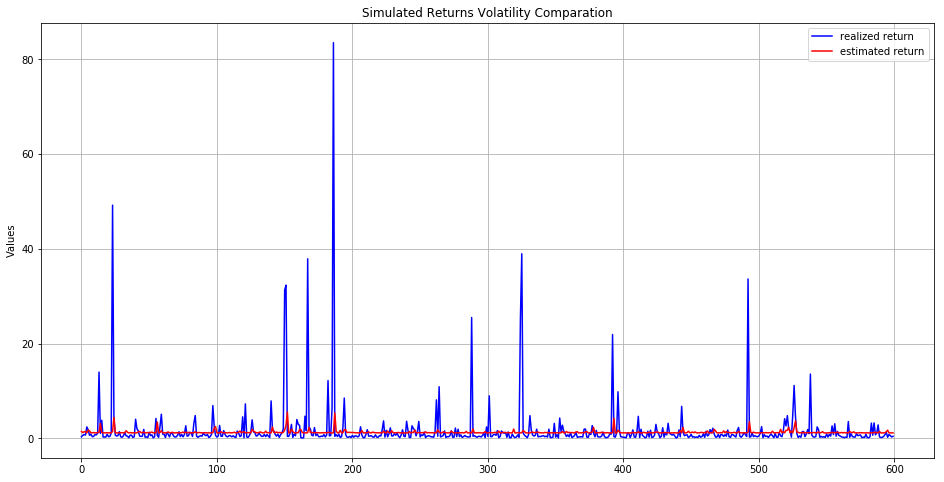

In [12]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.ylabel('Values')
plt.title('Simulated Returns Volatility Comparation')
plt.plot(sim_realized_vol, color='blue', label='realized return')
plt.plot(sim_am_fit.conditional_volatility, color='red', label='estimated return')
plt.legend()
plt.plot()
plt.show()

Comment: for simulated returns, realized volatility has a larger variance than estimated volatility.

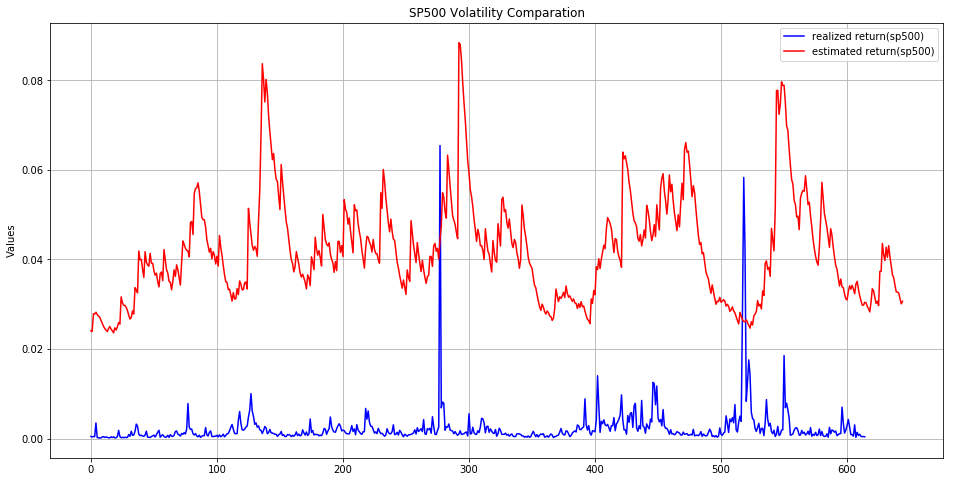

In [13]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.ylabel('Values')
plt.title('SP500 Volatility Comparation')
plt.plot(sp500_realized_vol, color='blue', label='realized return(sp500)')
plt.plot(sp500_am_fit.conditional_volatility, color='red', label='estimated return(sp500)')
plt.legend()
plt.plot()
plt.show()

Comment: for SP500 returns, estimated volatility has a larger variance than realized volatility.

## 3.5

In [14]:
sim_ar = sm.tsa.ARIMA(sim_realized_vol, order=(1,0,0)) 
sim_ar_fit = sim_ar.fit(disp=0)
print(sim_ar_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  600
Model:                     ARMA(1, 0)   Log Likelihood               -1863.573
Method:                       css-mle   S.D. of innovations              5.403
Date:                Wed, 17 Feb 2021   AIC                           3733.146
Time:                        21:02:07   BIC                           3746.337
Sample:                             0   HQIC                          3738.281
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7243      0.252      6.843      0.000       1.230       2.218
ar.L1.y        0.1248      0.040      3.083      0.002       0.045       0.204
                                    Roots           

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


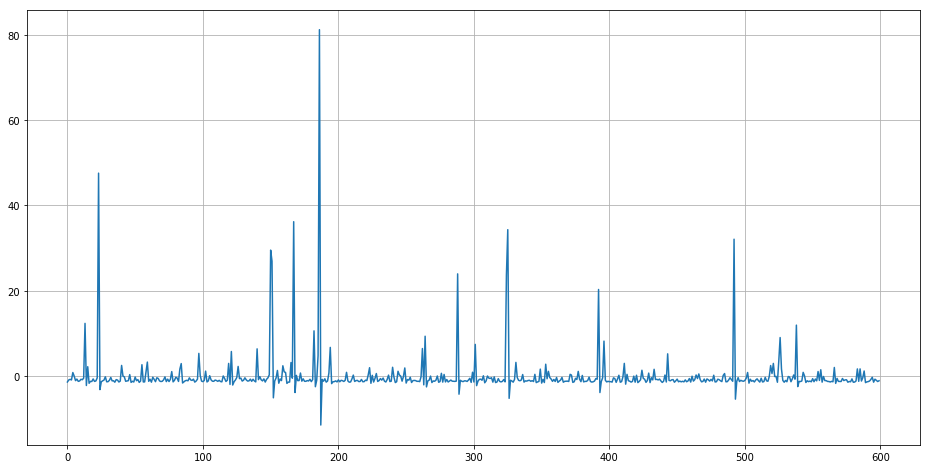

In [15]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(sim_ar_fit.resid)

$\sigma_t^2 = 1.7243 + 0.1248\sigma_{t-1}^2$

In [16]:
sp500_ar = sm.tsa.ARIMA(sp500_realized_vol, order=(1,0,0)) 
sp500_ar_fit = sp500_ar.fit(disp=0)
print(sp500_ar_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  615
Model:                     ARMA(1, 0)   Log Likelihood                2540.938
Method:                       css-mle   S.D. of innovations              0.004
Date:                Wed, 17 Feb 2021   AIC                          -5075.875
Time:                        21:02:07   BIC                          -5062.610
Sample:                             0   HQIC                         -5070.717
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      7.171      0.000       0.002       0.003
ar.L1.y        0.5014      0.035     14.393      0.000       0.433       0.570
                                    Roots           

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


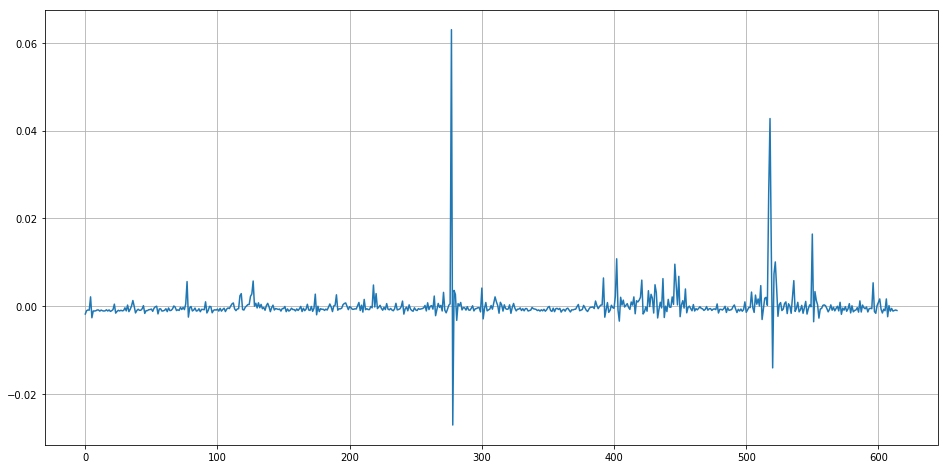

In [17]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(sp500_ar_fit.resid)

$\sigma_t^2 = 0.0022 + 0.5014\sigma_{t-1}^2$

Comment: for both dataset, the residuals from an AR(1) model showed GARCH behavior(volatility clustering).

## 3.6

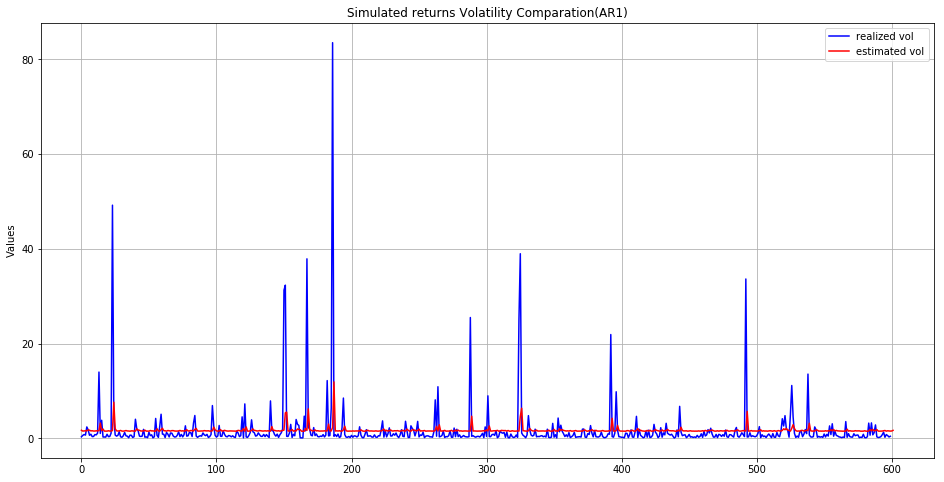

In [18]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.ylabel('Values')
plt.title('Simulated returns Volatility Comparation(AR1)')
plt.plot(sim_realized_vol, color='blue', label='realized vol')
plt.plot(sim_ar_fit.predict(start=0, end=601), color='red', label='estimated vol')
plt.legend()
plt.plot()
plt.show()

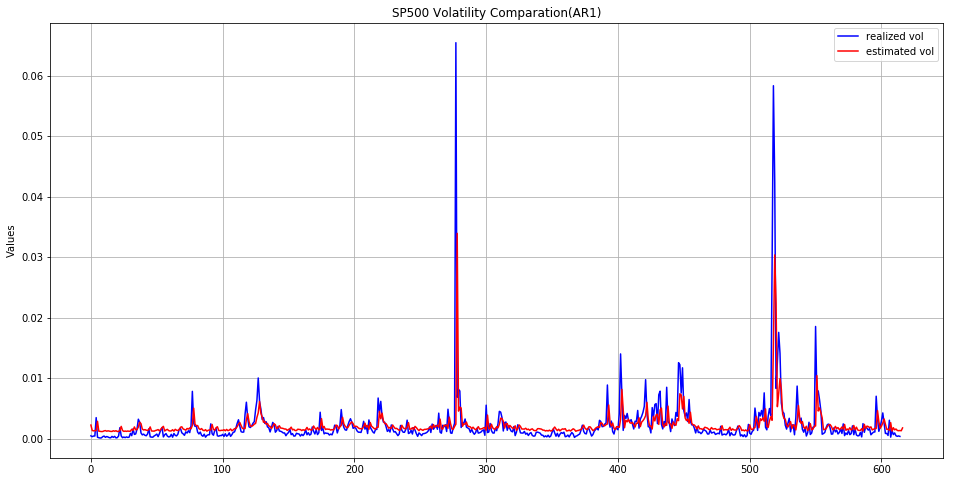

In [19]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.ylabel('Values')
plt.title('SP500 Volatility Comparation(AR1)')
plt.plot(sp500_realized_vol, color='blue', label='realized vol')
plt.plot(sp500_ar_fit.predict(start=0, end=616), color='red', label='estimated vol')
plt.legend()
plt.plot()
plt.show()

## 3.7

In [20]:
# MSE of the AR(1) forecasts (simulated returns)
mse = mean_squared_error(sim_ar_fit.predict(), sim_realized_vol)
print('MSE: '+str(mse))

MSE: 29.19533587236354


In [21]:
# MSE of the AR(1) forecasts (SP500 returns)
mse = mean_squared_error(sp500_ar_fit.predict(), sp500_realized_vol)
print('MSE: '+str(mse))

MSE: 1.5090067997866108e-05


## 3.8

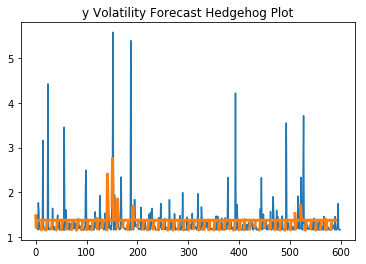

In [22]:
plot = sim_am_fit.hedgehog_plot()

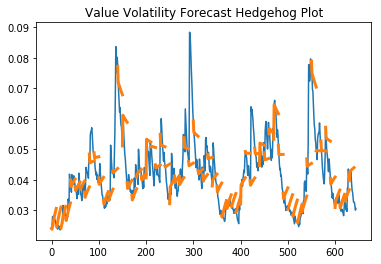

In [23]:
plot = sp500_am_fit.hedgehog_plot()

## 3.9

In [24]:
# MSE of the AR(1) forecasts (simulated returns)
mse = mean_squared_error(sim_am_fit.conditional_volatility, sim_realized_vol)
print('MSE: '+str(mse))

MSE: 29.741459534195045


In [25]:
# MSE of the AR(1) forecasts (SP500 returns)
mse = mean_squared_error(sp500_am_fit.conditional_volatility[:len(sp500_realized_vol)], sp500_realized_vol)
print('MSE: '+str(mse))

MSE: 0.0017705720218543573


# Question 4

## 4.1 GMM

In [26]:
kappa = 0.234
theta = 0.081
sigma_sqr = 0.0073

In [27]:
np.sqrt(0.0073)

0.08544003745317531

In [28]:
np.random.seed(100)

In [29]:
interest_rate = pd.read_csv('interest_rates.csv')

In [30]:
rates = interest_rate['NFCP_M1']

In [31]:
n = 100000
steps = 250
delta = 1/steps

sim_rates = np.zeros(int(n/steps))
ir = theta

cur = 0

for i in range(n):
    epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma_sqr*ir*delta))
    ir = ir + kappa*(theta-ir)*delta + epsilon
    if (i+1) % 250 == 0:
        sim_rates[cur] = ir
        cur+=1

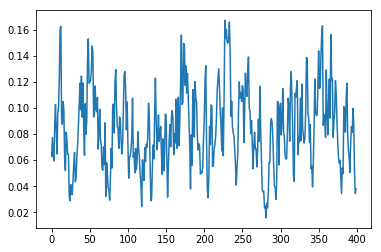

In [32]:
plt.plot(sim_rates)

### Simulated Data 

In [33]:
rt_new = sim_rates[1:]
rt_old = sim_rates[:-1]

def moments(endog, exog, params):
    kappa, theta, sig = params
    delta = 1
    h1 = (endog - exog - kappa * (theta - exog) * delta)
    h2 = h1 * exog
    h3 = ((endog - exog - kappa * (theta - exog) * delta)**2) - (sig**2)*exog*delta
    h4 = h3 * exog
    
    g = np.column_stack((h1, h2, h3, h4))
    
    return g

In [34]:
class gmm(GMM):
    
    def momcond(self, params):

        endog = self.endog
        exog = self.exog.squeeze()
        
        return moments(endog, exog, params)

In [35]:
beta0 = np.array([kappa, theta, np.sqrt(sigma_sqr)])
inst = np.column_stack((np.ones(len(rt_new)), rt_new))

mm = gmm(endog=rt_new, exog=rt_old, maxiter=1000, instrument=inst, k_moms=4, k_params=3, missing='none')

In [36]:
res = mm.fit(beta0)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002534
         Iterations: 9
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.004808
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.003391
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.005233
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002842
         Iterations: 5
         Function evaluations: 9
         Grad

In [37]:
delta = 1
k,t,s = res.params
print(k,t,s)

0.28437355842459117 0.0841028972461179 0.0744774728745909


The estimated three parameters $\kappa$, $\theta$ and $\sigma$ by GMM is represented above respectively. 

Compared with result from real data:

In [38]:
delta = 1
rt_real_new = rates[1:]
rt_real_old = rates[:-1]

def gmm_initial(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    h1 = rt_real_new - rt_real_old - kappa*(theta - rt_real_old)*delta
    h2 = h1*rt_real_old
    h3 = h1**2 - sigma_sqr*rt_real_old*delta
    h4 = h3*rt_real_old
    
    g = np.column_stack((h1, h2, h3, h4)).mean(axis=0)
    
    obj = np.sum(g**2)
    
    return obj

gmm_optimal_real = optimize.fmin(gmm_initial, [0.2, 0.1, 0.01], maxiter=1000)
print(gmm_optimal_real)

[0.2  0.1  0.01]


Now, back to simulated data, calculate covariance matrix W and take W_prime = inverse(W) as the new weight matrix:

In [39]:
endog = rt_new
exog = rt_old

error1 = (endog - exog - k * (t - exog) * delta)
error2 = error1 * exog
error3 = error1**2 - s**2*exog*delta
error4 = error3 * exog

g = np.column_stack((error1, error2, error3, error4))/(len(endog))

In [40]:
W = mm.calc_weightmatrix(moms = g, weights_method='cov', wargs=(), params=None)
W_prime = np.linalg.inv(W)

In [41]:
print(W)

[[2.93353873e-09 2.64853313e-10 1.77491761e-11 1.12594577e-12]
 [2.64853313e-10 2.67267470e-11 1.12870251e-12 5.55688697e-14]
 [1.77491761e-11 1.12870251e-12 2.42776394e-12 2.24676598e-13]
 [1.12594577e-12 5.55688697e-14 2.24676598e-13 2.39031606e-14]]


In [42]:
print(W_prime) # inverse

[[ 3.44411477e+09 -3.36482744e+10 -1.35359195e+10  4.32208319e+10]
 [-3.36482744e+10  3.68054488e+11  5.67768223e+10  1.95678594e+11]
 [-1.35359195e+10  5.67768223e+10  3.36333367e+12 -3.11078812e+13]
 [ 4.32208319e+10  1.95678594e+11 -3.11078812e+13  3.31741694e+14]]


In [43]:
res2 = mm.fit(beta0, inv_weights = W_prime)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000314
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.015799
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000406
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.015974
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000404
         Iterations: 7
         Function evaluations: 10
         Gra

Report standard errors for each estimate by the covariance matrix W:

In [44]:
diag = np.sqrt(np.diag(W))
diag*(1/math.sqrt(len(sim_rates)))

array([2.70810761e-06, 2.58489589e-07, 7.79064173e-08, 7.73032351e-09])

Now, estimate the new parameters with the new weight matrix W_prime

In [45]:
delta = 1
rt_new = sim_rates[1:]
rt_old = sim_rates[:-1]

def gmm_sim(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    h1 = rt_new - rt_old - kappa*(theta - rt_old)*delta
    h2 = h1*rt_old
    h3 = h1**2 - sigma_sqr*rt_old*delta
    h4 = h3*rt_old
    
    g = np.column_stack((h1, h2, h3, h4)).mean(axis=0)
    
    obj = np.sum(np.transpose(g)*W_prime*g)
    
    return obj



In [46]:
gmm_optimal_sim_new_weight = optimize.fmin(gmm_sim, [0.2, 0.1, 0.01], maxiter=1000)
print(gmm_optimal_sim_new_weight)

[-9.15951495e+22 -5.82096721e+50  1.14729229e+50]


/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/scipy/optimize/optimize.py:734: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


## 4.2 QML

In [47]:
delta = 1

In [48]:
def qml_sim(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    mu_rt = sim_rates * np.exp(-kappa*delta) + theta * (1-np.exp(-kappa*delta))
    sigma_sqr_rt = sim_rates * sigma_sqr / kappa *(np.exp(-kappa*delta) - np.exp(-2*kappa)) + theta * sigma_sqr / (2*kappa*delta) * (1 - np.exp(- kappa*delta))**2
    
    mu_rt = mu_rt[:-1]
    sigma_sqr_rt = sigma_sqr_rt[:-1]
    rt = sim_rates[1:]
  
    return np.sum(np.log(sigma_sqr_rt) + (rt-mu_rt)**2/sigma_sqr_rt)/len(sim_rates)

def qml_rates(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    mu_rt = rates * np.exp(-kappa*delta) + theta * (1-np.exp(-kappa*delta))
    sigma_sqr_rt = rates * sigma_sqr / kappa *(np.exp(-kappa*delta) - np.exp(-2*kappa)) + theta * sigma_sqr / (2*kappa*delta) * (1 - np.exp(- kappa*delta))**2
    
    mu_rt = mu_rt[:-1]
    sigma_sqr_rt = sigma_sqr_rt[:-1]
    rt = rates[1:]
  
    return np.sum(np.log(sigma_sqr_rt) + (rt-mu_rt)**2/sigma_sqr_rt)/len(rates)

In [49]:
qml_optimal_sim = optimize.fmin(qml_sim, [0.2, 0.1, 0.01], maxiter=1000)
print(qml_optimal_sim)

qml_optimal_rates = optimize.fmin(qml_rates, [0.2, 0.1, 0.01], maxiter=1000)
print(qml_optimal_rates)

Optimization terminated successfully.
         Current function value: -6.665843
         Iterations: 64
         Function evaluations: 116
[0.31486353 0.08421142 0.00773132]


/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


Optimization terminated successfully.
         Current function value: -65.567240
         Iterations: 410
         Function evaluations: 773
[1.35971836e-16 2.34850676e-01 1.24555219e-31]


To numerically calculate the derivatives for the covariance matrix from 4.2 to 4.4, it could be done with the aim of functions written below,

In [50]:
def first_derivative(gamma, f):
    
    tol = 1e-8
    
    g_1 = gamma.copy()
    g_1[0] += tol
    g_2 = gamma.copy()
    g_2[0] -= tol
    g_first = (f(g_1) - f(g_2))/(2*tol)
    
    g_1 = gamma.copy()
    g_1[1] += tol
    g_2 = gamma.copy()
    g_2[1] -= tol
    g_second = (f(g_1) - f(g_2))/(2*tol)

    g_1 = gamma.copy()
    g_1[2] += tol
    g_2 = gamma.copy()
    g_2[2] -= tol
    g_third = (f(g_1) - f(g_2))/(2*tol)

    derivative = np.array([g_first, g_second, g_third])

    return derivative

In [51]:
def second_gradient(gamma, f):

    tol = 1e-8

    g_1 = gamma.copy()
    g_1[0] += tol
    g_2 = gamma.copy()
    g_2[0] -= tol
    g_first = (first_derivative(g_1, f) - first_derivative(g_2, f))/(2*tol)
    
    g_1 = gamma.copy()
    g_1[1] += tol
    g_2 = gamma.copy()
    g_2[1] -= tol
    g_second = (first_derivative(g_1, f) - first_derivative(g_2, f))/(2*tol)
    
    g_1 = gamma.copy()
    g_1[2] += tol
    g_2 = gamma.copy()
    g_2[2] -= tol
    g_third = (first_derivative(g_1, f) - first_derivative(g_2, f))/(2*tol)
    
    derivative = np.array([g_first, g_second, g_third])
    
    return derivative

Then, by passing in our optimal estimates and likelihood function into the functions above, we could then get the covariance matrix with `{linalg.inv() @ I@ linalg()}`. This also applies to the section 4.3 and 4.4 in calculating covariance matrix. 

## 4.3 Transformed Approximated Likelihood

In [52]:
y_sim = 2 * np.sqrt(sim_rates)
y_rates = 2 * np.sqrt(rates)

In [53]:
def trans_sim(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    yt = y_sim[:-1]
    
    a = 2/yt *(kappa * theta - sigma_sqr/4) - kappa *yt/2
    b = -2/(yt**2) *(kappa * theta - sigma_sqr/4) - kappa/2
    c = 4/(yt**3) *(kappa * theta - sigma_sqr/4)
    K = np.exp(b*delta) - 1
    v = sigma_sqr/(2*b) * (np.exp(2*b*delta)-1)
    m = yt + a/b*K + sigma_sqr * c / (2*b**2) * (K - b)
    l = np.sum((y_sim[1:] - m)/(2*v) + 1/2 * np.log(2 * np.pi * v))
    
    return l/len(y_sim)

def trans_rates(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    yt = y_rates[:-1]
    
    a = 2/yt *(kappa * theta - sigma_sqr/4) - kappa *yt/2
    b = -2/(yt**2) *(kappa * theta - sigma_sqr/4) - kappa/2
    c = 4/(yt**3) *(kappa * theta - sigma_sqr/4)
    K = np.exp(b) - 1
    v = sigma_sqr/ 2/ b * (np.exp(2*b)-1)
    m = yt + a/b*K + sigma_sqr * c / (2*b**2) * (K - b)
    l = np.sum((y_rates[1:] - m)/(2*v) + 1/2 * np.log(2 * np.pi * v))
    
    return l/len(y_rates)

In [54]:
trans_optimal_sim = optimize.fmin(trans_sim, [0.2, 0.1, 0.01], maxiter=1000)
print(trans_optimal_sim)

trans_optimal_rates = optimize.fmin(trans_rates, [0.2, 0.1, 0.01], maxiter=1000)
print(trans_optimal_rates)

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


[2.65459149e-01 1.81994851e-01 2.81600286e-92]


/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


[-1.13161774e+00  4.71622701e-01  1.69450684e-90]


## 4.4 Exact Likelihood for the CIR model

In [55]:
def exact_CIR_sim(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    c = 2 * kappa / ((sigma_sqr)*(1- np.exp(-kappa*delta)))
    u = c * sim_rates[:-1] * np.exp(-kappa*delta)
    v = c * sim_rates[1:]
    q = 2 * kappa * theta / sigma_sqr - 1
    I = scipy.special.iv(1, 2* np.sqrt(u*v))
    f = -np.log(c * np.exp(-u-v) * (v/u) ** (q/2) * I)
    
    return np.sum(f)

def exact_CIR_rates(gamma):
    
    kappa, theta, sigma_sqr = gamma
    
    c = 2 * kappa / ((sigma_sqr)*(1- np.exp(-kappa*delta)))
    u = c * rates[:-1] * np.exp(-kappa*delta)
    v = c * rates[1:]
    q = 2 * kappa * theta / sigma_sqr - 1
    I = scipy.special.iv(1, 2* np.sqrt(u*v))
    f = -np.log(c * np.exp(-u-v) * (v/u) ** (q/2) * I)
    
    return np.sum(f)

In [56]:
exact_optimal_sim = optimize.fmin(exact_CIR_sim, [0.2, 0.1, 0.01], maxiter=1000)
print(exact_optimal_sim)

exact_optimal_rates = optimize.fmin(exact_CIR_rates, [0.2, 0.1, 0.01], maxiter=1000)
print(exact_optimal_rates)

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in power
  # Remove the CWD from sys.path while we load stuff.
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountere

[0.34729966 0.13012886 0.00088032]
[0.2  0.1  0.01]
